# Time Series Analysis (TSA)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [182]:
# Finding available dataset names in seaborn
print(sns.get_dataset_names())

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']


In [183]:
df = sns.load_dataset('flights')
df.head()
#We get only year and month for the date, we need day also

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [184]:
# Convert the date to a YYYY-MM-DD format in a new column named yearMonth
df['yearMonth'] = "01-"+df['month'].astype(str)+"-"+df['year'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
 3   yearMonth   144 non-null    object  
dtypes: category(1), int64(2), object(1)
memory usage: 4.0+ KB


In [185]:
# yearMonth is of type object - we may have problem later, so convert it into datetime
df['yearMonth'] = pd.to_datetime("01-"+df['month'].astype(str)+"-"+df['year'].astype(str)) 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        144 non-null    int64         
 1   month       144 non-null    category      
 2   passengers  144 non-null    int64         
 3   yearMonth   144 non-null    datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(2)
memory usage: 4.0 KB


,year,month,passengers,yearMonth
0,1949,Jan,112,1949-01-01
1,1949,Feb,118,1949-02-01
2,1949,Mar,132,1949-03-01
3,1949,Apr,129,1949-04-01
4,1949,May,121,1949-05-01


In [186]:
# Make yearMonth column as the dataframe index
df.set_index('yearMonth', inplace=True)      # Inplace will make the change permanent to the DF
df.head()

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


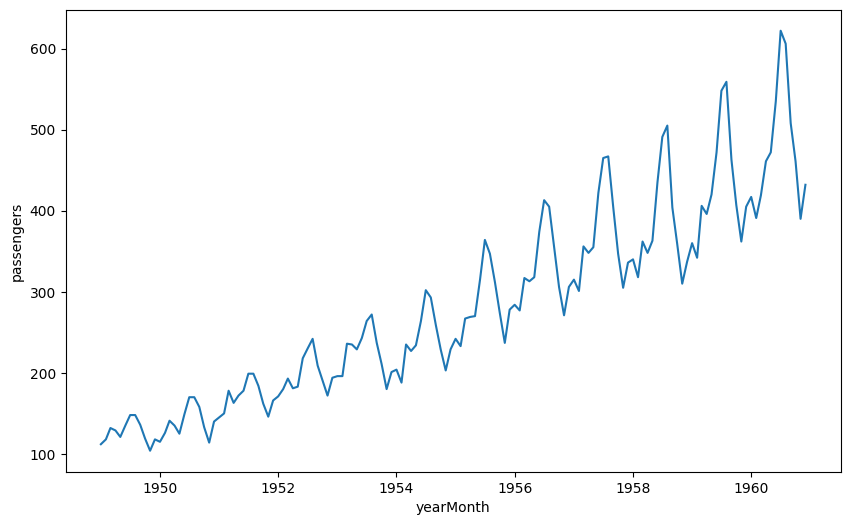

In [187]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x=df.index, y=df.passengers)
plt.show()

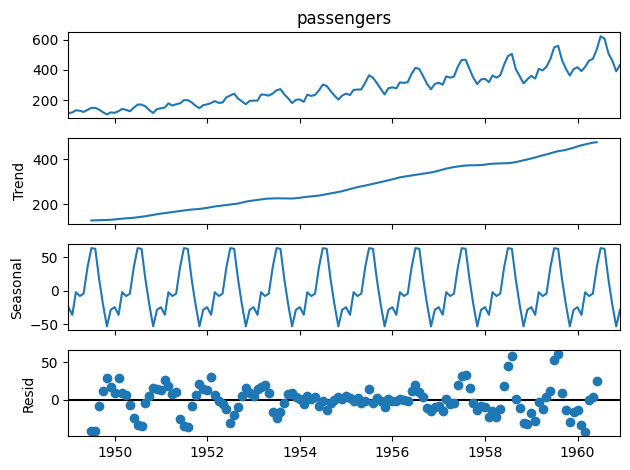

In [188]:
# Check further for seasonlaity and trend
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df.passengers, period = 12)
fig = decomposition.plot()
# Upward trend and cleat seasonality

- We see in our graph two patterns : seasonality and trend

In [189]:
# Check further for seasonality and trend
# Calculate the plot rolling mean and standard deviation for 12 months
df['rollMean'] = df.passengers.rolling(window=12).mean()
df['rollStd'] = df.passengers.rolling(window=12).std()
df['rollMean']
df['rollStd']

yearMonth
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
                ...    
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125
Name: rollStd, Length: 144, dtype: float64

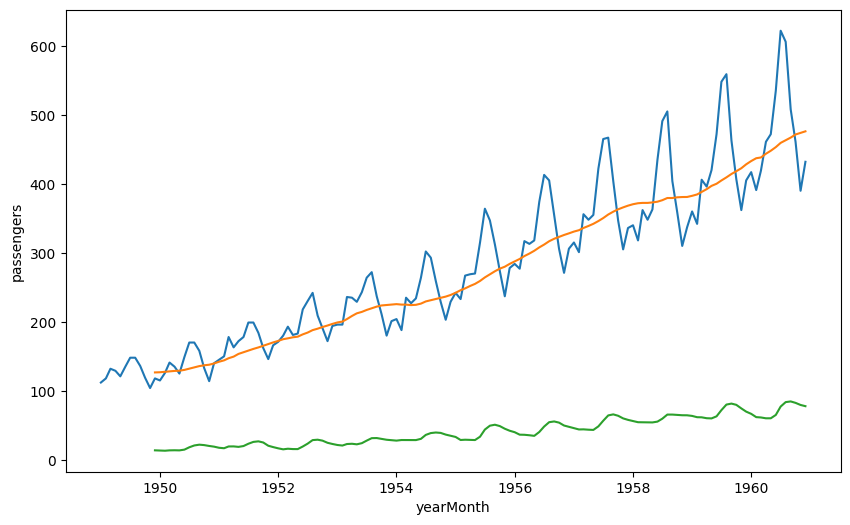

In [190]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x=df.index, y=df.passengers)  #blue
sns.lineplot(data=df, x=df.index, y=df.rollMean)    #yellow
sns.lineplot(data=df, x=df.index, y=df.rollStd)     #green
plt.show()

- Mean is not stationary , SD is stationary

## ADF Test
    - Now let us perform ADF Test

In [191]:
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df['passengers'])
adfTest

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [192]:
# Let us interpret these values below by converting into a series 
stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
stats

Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
dtype: float64

    - H0: Time Series is not stationary
    - p-value >= 0.05: Do not reject null hypothesis
    - ADF Statistics is less negative (or more positive) than the critical value 
    - Do not reject the null hypothesis, meaning the series is non-stationary

In [193]:
for key, values in adfTest[4].items():
    print('criticality', key, ":", values)

criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


    - We will see that our test statistics > Critical values in all the cases, so we do not reject the null hypothesis. 
    - It means that our data is not stationary

## Time Shift
    - trying to make time stationary

In [194]:
# Just get the passengers column into a new dataframe for easier testing
air_df = df[['passengers']].copy()      # Double [[]] brackets becuase it is a list within a list
air_df.head()

,passengers
yearMonth,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [195]:
# By default, shift is by 1 time period (here, one month)
# Create a new column which will contain the shiftedvalue from passengers  column 
air_df['shift'] = air_df.passengers.shift(1)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
air_df.head(10)

,passengers,shift,shiftDiff
yearMonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,112.0,6.0
1949-03-01,132,118.0,14.0
1949-04-01,129,132.0,-3.0
1949-05-01,121,129.0,-8.0
1949-06-01,135,121.0,14.0
1949-07-01,148,135.0,13.0
1949-08-01,148,148.0,0.0
1949-09-01,136,148.0,-12.0


In [196]:
# The previous code to test stationarity is now in a function
def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var])
    stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
    print(stats)
    
    for key, values in adfTest[4].items():
        print('criticality', key, ":", values)
    
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.shiftDiff)  #blue
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollMean)    #yellow
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollStd)     #green
    plt.show()

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


Test Statistic                  -2.829267
p-value                          0.054213
#lags used                      12.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


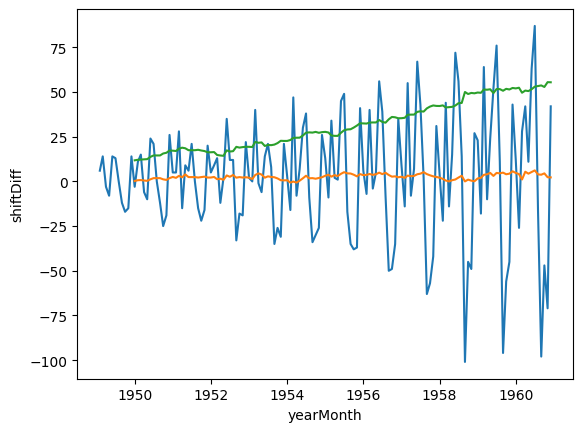

In [197]:
# Test stationarity
test_stationarity(air_df.dropna(), 'shiftDiff')

    - p-value is just close to 0.05, so let's us try a shift of 2

In [198]:
# By default, shift is by 1 time period (here, one month)
# Create a new column which will contain the shiftedvalue from passengers  column 
air_df['shift'] = air_df.passengers.shift(2)
air_df['shiftDiff'] = air_df['passengers'] - air_df['shift']
air_df.head(10)

,passengers,shift,shiftDiff
yearMonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,112.0,20.0
1949-04-01,129,118.0,11.0
1949-05-01,121,132.0,-11.0
1949-06-01,135,129.0,6.0
1949-07-01,148,121.0,27.0
1949-08-01,148,135.0,13.0
1949-09-01,136,148.0,-12.0


Test Statistic                  -2.961695
p-value                          0.038630
#lags used                      11.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


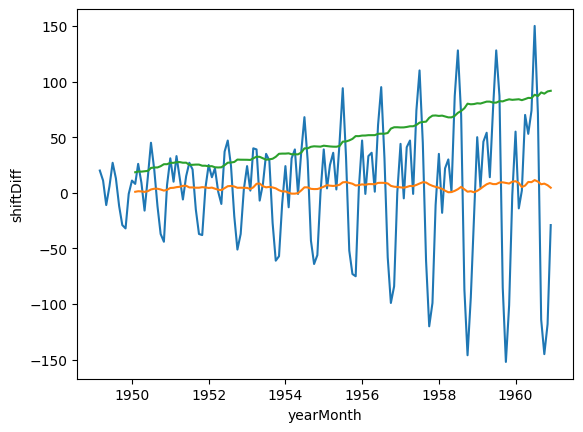

In [199]:
# Test stationarity
test_stationarity(air_df.dropna(), 'shiftDiff')

    - -2.96 < -2.88 and p-value=0.03, which is < 0.05, so ,now
    - now test statistic < critical value .... now we reject H0
    - Conclusion : The data has somewhat became stationary

## ARIMA (AutoRegressive Integrated Moving Average)

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [201]:
# Cretae columns for one month and one year lagged data
air_df['firstDiff'] = air_df['passengers'].diff()
air_df.head()

,passengers,shift,shiftDiff,firstDiff
yearMonth,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,6.0
1949-03-01,132,112.0,20.0,14.0
1949-04-01,129,118.0,11.0,-3.0
1949-05-01,121,132.0,-11.0,-8.0


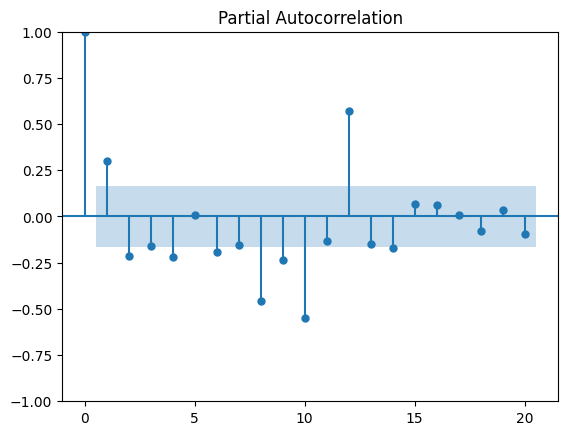

In [202]:
plot_pacf(air_df['firstDiff'].dropna(), lags=20)
plt.show()

    - shaded area is the insignificant area
    - PACF gives us the auto regressive values (i.e p - Refer to the slide)
    - Firt 'p is 1 (the x axis coordinate) whose value is ~0.31 (y-axis coordinate)
    - So significant p-values are 1,2,4,6 etc

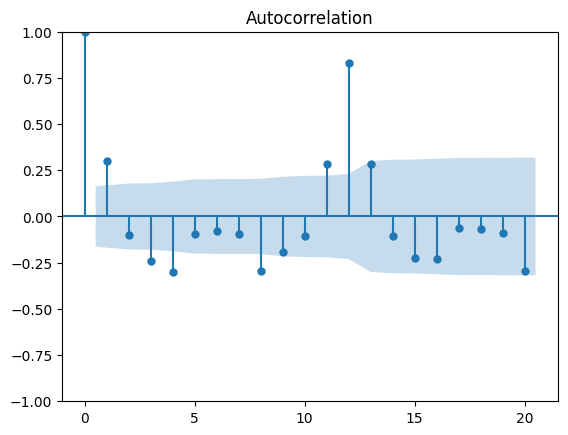

In [203]:
# Now let us take this value as p and find q, for which we need ACF 
plot_acf(air_df['firstDiff'].dropna(), lags=20)
plt.show()

    - Results of ACF are similar to that of PACF
    - We got q. Significant q values are 1,3,4,8

In [204]:
# let us take p = 1, q = 3 (both are significant) and d=2 (already known)
# Build ARIMA Model
train = air_df[:round(len(air_df)*70/100)]      # take the first 70% data
train.tail()    # just to check where it ends
test = air_df[round(len(air_df)*70/100):]       # Take the last 30% data, starting from 71%
test.head()        

,passengers,shift,shiftDiff,firstDiff
yearMonth,,,,
1957-06-01,422,348.0,74.0,67.0
1957-07-01,465,355.0,110.0,43.0
1957-08-01,467,422.0,45.0,2.0
1957-09-01,404,465.0,-61.0,-63.0
1957-10-01,347,467.0,-120.0,-57.0


In [205]:
model = ARIMA(train['passengers'], order=(1,2,3))       # Parameters: p, d,q
model_fit = model.fit()

prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
air_df['arimaPred'] = prediction

c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [206]:
air_df.tail()

,passengers,shift,shiftDiff,firstDiff,arimaPred
yearMonth,,,,,
1960-08-01,606,535.0,71.0,-16.0,462.073152
1960-09-01,508,622.0,-114.0,-98.0,464.613357
1960-10-01,461,606.0,-145.0,-47.0,467.153578
1960-11-01,390,508.0,-118.0,-71.0,469.693789
1960-12-01,432,461.0,-29.0,42.0,472.234006


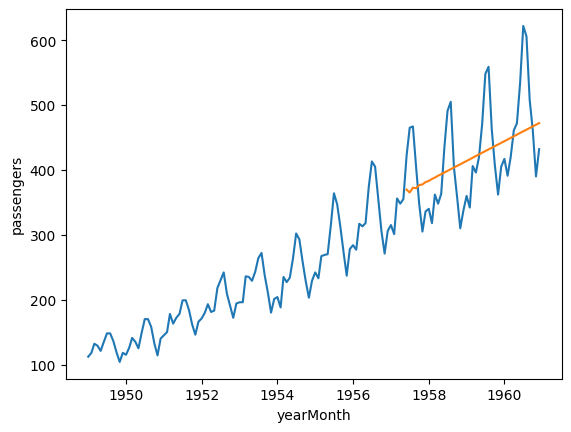

In [207]:
# plot
sns.lineplot(data=air_df, x=air_df.index, y='passengers')
sns.lineplot(data=air_df, x=air_df.index, y='arimaPred')
plt.show()

    - Conclusion : The ARIMA prediction is not good

## SARIMAX (Seasonal AutoRegressive Integrated Moving Average Exogenous)

In [208]:
air_df['Diff12'] = air_df['passengers'].diff(12)    #this will show null to start with
air_df.head(20)

,passengers,shift,shiftDiff,firstDiff,arimaPred,Diff12
yearMonth,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,6.0,NaN,NaN
1949-03-01,132,112.0,20.0,14.0,NaN,NaN
1949-04-01,129,118.0,11.0,-3.0,NaN,NaN
1949-05-01,121,132.0,-11.0,-8.0,NaN,NaN
1949-06-01,135,129.0,6.0,14.0,NaN,NaN
1949-07-01,148,121.0,27.0,13.0,NaN,NaN
1949-08-01,148,135.0,13.0,0.0,NaN,NaN
1949-09-01,136,148.0,-12.0,-12.0,NaN,NaN


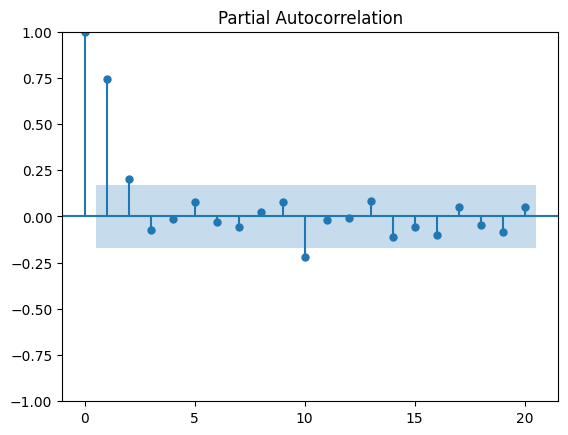

In [209]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plot_pacf(air_df['Diff12'].dropna(), lags=20)
plt.show()

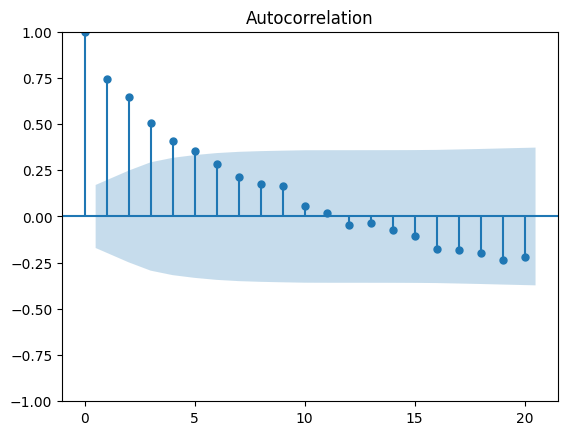

In [210]:
plot_acf(air_df['Diff12'].dropna(), lags=20)
plt.show()

In [211]:
train = air_df[:round(len(air_df)*70/100)]      # take the first 70% data

test = air_df[round(len(air_df)*70/100):]       # Take the last 30% data, starting from 71%


In [212]:
# Now SARIMAX predictions
model = SARIMAX(train['passengers'], order=(1,2,1), seasonal_order=(1,2,1,12))
model_fit = model.fit()
prediction= model_fit.predict(start=test.index[0], end=test.index[-1])
air_df['sarimaxPred'] = prediction
air_df.tail()

c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,passengers,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
yearMonth,,,,,,,
1960-08-01,606,535.0,71.0,-16.0,462.073152,47.0,588.757837
1960-09-01,508,622.0,-114.0,-98.0,464.613357,45.0,518.372251
1960-10-01,461,606.0,-145.0,-47.0,467.153578,54.0,452.598394
1960-11-01,390,508.0,-118.0,-71.0,469.693789,28.0,402.818634
1960-12-01,432,461.0,-29.0,42.0,472.234006,27.0,450.797347


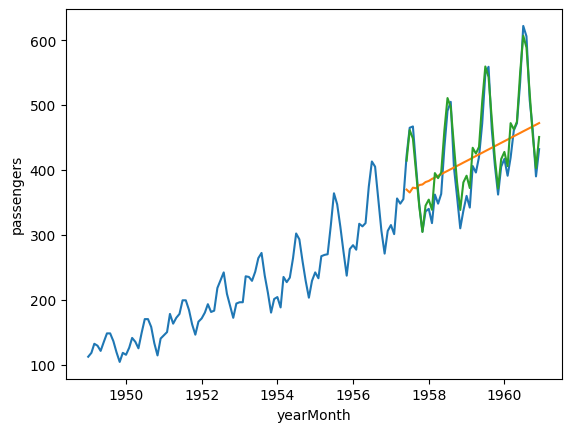

In [213]:
# plot
sns.lineplot(data=air_df, x=air_df.index, y='passengers')
sns.lineplot(data=air_df, x=air_df.index, y='arimaPred')
sns.lineplot(data=air_df, x=air_df.index, y='sarimaxPred')
plt.show()

    - Compared to ARIMA, SARIMAX is much better
    

    - Future Predictions

In [214]:
air_df.head()

,passengers,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
yearMonth,,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,6.0,NaN,NaN,NaN
1949-03-01,132,112.0,20.0,14.0,NaN,NaN,NaN
1949-04-01,129,118.0,11.0,-3.0,NaN,NaN,NaN
1949-05-01,121,132.0,-11.0,-8.0,NaN,NaN,NaN


In [215]:
# MS : Month Start frequency
# Create a data frame to hold index values from 01.01.61 to 01.12.62
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01', freq='MS'), columns=['Dates'])
futureDate.set_index('Dates', inplace=True)
futureDate.head()


""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


In [216]:
# Predict and Print
print(model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]))

1961-01-01    462.562282
1961-02-01    437.554044
1961-03-01    508.351914
1961-04-01    497.731609
1961-05-01    511.035337
1961-06-01    591.675415
1961-07-01    652.335293
1961-08-01    632.027686
1961-09-01    555.849656
1961-10-01    485.351753
1961-11-01    431.998512
1961-12-01    482.563067
1962-01-01    494.964030
1962-02-01    466.805924
1962-03-01    541.954952
1962-04-01    530.328942
1962-05-01    545.054943
1962-06-01    630.738859
1962-07-01    694.850664
1962-08-01    672.400287
1962-09-01    590.329998
1962-10-01    515.018548
1962-11-01    458.042982
1962-12-01    511.095882
Freq: MS, Name: predicted_mean, dtype: float64


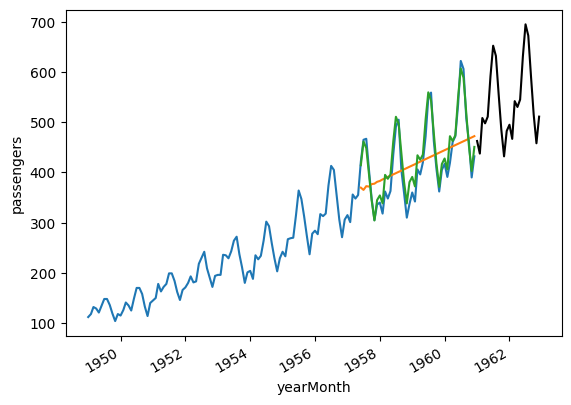

In [217]:
# plot
sns.lineplot(data=air_df, x=air_df.index, y='passengers')
sns.lineplot(data=air_df, x=air_df.index, y='arimaPred')
sns.lineplot(data=air_df, x=air_df.index, y='sarimaxPred')
model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot(color='black')
plt.show()

# Exercises on TSA

## Cola Production Dataset

In [218]:
cola_df = pd.read_csv("./data_pd/monthly-cola-production-in-austr.csv")
cola_df.head()

,Month,Monthly cola production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [219]:
# Convert the date to a YYYY-MM-DD format in a new column named yearMonth
cola_df['yearMonth'] = cola_df['Month'].astype(str) + "-01"
cola_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly cola production  476 non-null    float64
 2   yearMonth                476 non-null    object 
dtypes: float64(1), object(2)
memory usage: 11.3+ KB


In [220]:
# yearMonth is of type object - we may have problem later, so convert it into datetime
cola_df['yearMonth'] = pd.to_datetime(cola_df['Month'].astype(str) + "-01") 
cola_df.info()
# cola_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    476 non-null    object        
 1   Monthly cola production  476 non-null    float64       
 2   yearMonth                476 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.3+ KB


In [221]:
# Make yearMonth column as the dataframe index
cola_df.set_index('yearMonth', inplace=True)      # Inplace will make the change permanent to the cola_df
cola_df.head()

,Month,Monthly cola production
yearMonth,,
1956-01-01,1956-01,93.2
1956-02-01,1956-02,96.0
1956-03-01,1956-03,95.2
1956-04-01,1956-04,77.1
1956-05-01,1956-05,70.9


In [350]:
cola_df.columns

Index(['Month', 'cola_production', 'yearMonth'], dtype='object')

In [222]:
cola_df = cola_df.rename(columns={'Monthly cola production': 'cola_production'})
cola_df.head()

,Month,cola_production
yearMonth,,
1956-01-01,1956-01,93.2
1956-02-01,1956-02,96.0
1956-03-01,1956-03,95.2
1956-04-01,1956-04,77.1
1956-05-01,1956-05,70.9


In [223]:
# Just get the passengers column into a new dataframe for easier testing
coke_df = cola_df[['cola_production']].copy()      # Double [[]] brackets becuase it is a list within a list
coke_df.head()

,cola_production
yearMonth,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [224]:
# By default, shift is by 1 time period (here, one month)
# Create a new column which will contain the shiftedvalue from passengers  column 
coke_df['shift'] = coke_df.cola_production.shift(1)
coke_df['shiftDiff'] = coke_df['cola_production'] - coke_df['shift']
coke_df.head(10)

,cola_production,shift,shiftDiff
yearMonth,,,
1956-01-01,93.2,NaN,NaN
1956-02-01,96.0,93.2,2.8
1956-03-01,95.2,96.0,-0.8
1956-04-01,77.1,95.2,-18.1
1956-05-01,70.9,77.1,-6.2
1956-06-01,64.8,70.9,-6.1
1956-07-01,70.1,64.8,5.3
1956-08-01,77.3,70.1,7.2
1956-09-01,79.5,77.3,2.2


In [225]:
# The previous code to test stationarity is now in a function
def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var])
    stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
    print(stats)
    
    for key, values in adfTest[4].items():
        print('criticality', key, ":", values)
    
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.shiftDiff)  #blue
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollMean)    #yellow
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollStd)     #green
    plt.show()

C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_19860\1448032339.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


Test Statistic                  -4.980664
p-value                          0.000024
#lags used                      18.000000
number of observations used    456.000000
dtype: float64
criticality 1% : -3.4447721346720885
criticality 5% : -2.8678991615065095
criticality 10% : -2.570157193174823


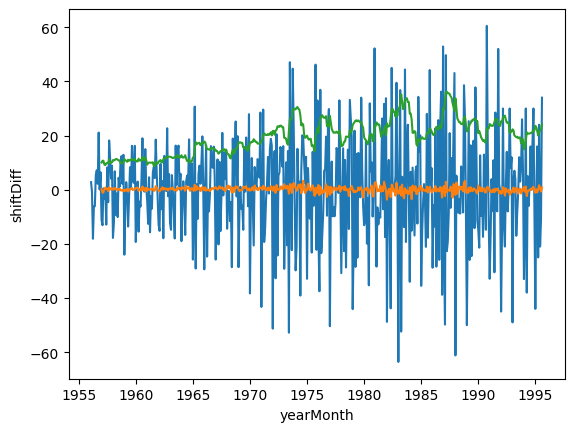

In [ ]:
# Test stationarity
test_stationarity(coke_df.dropna(), 'shiftDiff')

In [ ]:
# Cretae columns for one month and one year lagged data
coke_df['firstDiff'] = coke_df['cola_production'].diff()
coke_df.head()

,cola_production,shift,shiftDiff,firstDiff
yearMonth,,,,
1956-01-01,93.2,NaN,NaN,NaN
1956-02-01,96.0,93.2,2.8,2.8
1956-03-01,95.2,96.0,-0.8,-0.8
1956-04-01,77.1,95.2,-18.1,-18.1
1956-05-01,70.9,77.1,-6.2,-6.2


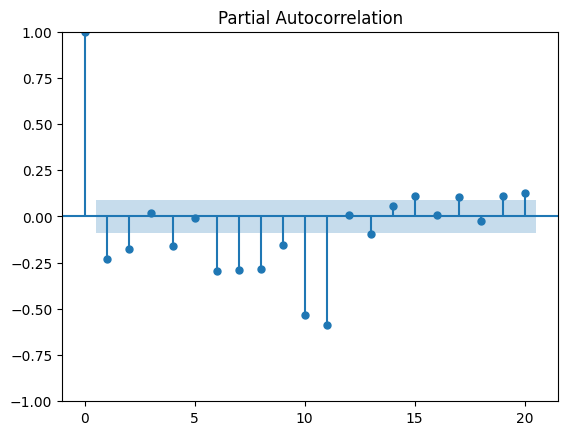

In [ ]:
plot_pacf(coke_df['firstDiff'].dropna(), lags=20)
plt.show()


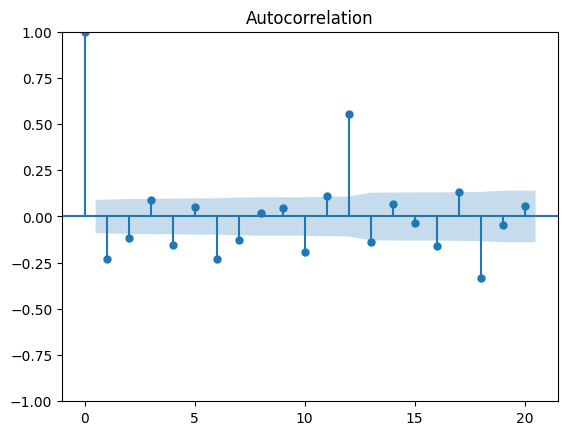

In [ ]:

plot_acf(coke_df['firstDiff'].dropna(), lags=20)
plt.show()

In [ ]:
# let us take p = 1, q = 1 (both are significant) and d=2 (already known)
# Build ARIMA Model
train = coke_df[:round(len(coke_df)*70/100)]      # take the first 70% data
train.tail()    # just to check where it ends
test = coke_df[round(len(coke_df)*70/100):]       # Take the last 30% data, starting from 71%
test.head()  

,cola_production,shift,shiftDiff,firstDiff
yearMonth,,,,
1983-10-01,162.8,146.8,16.0,16.0
1983-11-01,186.8,162.8,24.0,24.0
1983-12-01,185.5,186.8,-1.3,-1.3
1984-01-01,151.5,185.5,-34.0,-34.0
1984-02-01,158.1,151.5,6.6,6.6


In [ ]:
model = ARIMA(train['cola_production'], order=(1,1,1))       # Parameters: p, d,q
model_fit = model.fit()

prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
coke_df['arimaPred'] = prediction

c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [276]:
coke_df.tail()

,cola_production,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
yearMonth,,,,,,,
1995-04-01,127.0,152.0,-25.0,-25.0,157.58907,-33.0,-207.568388
1995-05-01,151.0,127.0,24.0,24.0,157.58907,-39.0,-182.765732
1995-06-01,130.0,151.0,-21.0,-21.0,157.58907,-52.0,-186.309593
1995-07-01,119.0,130.0,-11.0,-11.0,157.58907,-19.0,-240.820207
1995-08-01,153.0,119.0,34.0,34.0,157.58907,17.0,-206.549996


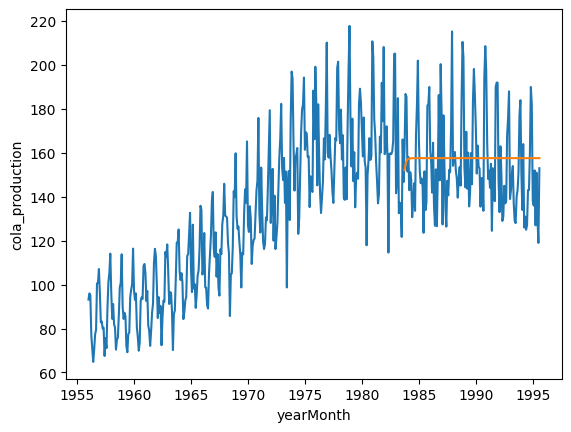

In [ ]:

# plot
sns.lineplot(data=coke_df, x=coke_df.index, y='cola_production')
sns.lineplot(data=coke_df, x=coke_df.index, y='arimaPred')
plt.show()

In [ ]:
coke_df['Diff12'] = coke_df['cola_production'].diff(6)    #this will show null to start with
coke_df.head(20)

,cola_production,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
yearMonth,,,,,,,
1956-01-01,93.2,NaN,NaN,NaN,NaN,NaN,NaN
1956-02-01,96.0,93.2,2.8,2.8,NaN,NaN,NaN
1956-03-01,95.2,96.0,-0.8,-0.8,NaN,NaN,NaN
1956-04-01,77.1,95.2,-18.1,-18.1,NaN,NaN,NaN
1956-05-01,70.9,77.1,-6.2,-6.2,NaN,NaN,NaN
1956-06-01,64.8,70.9,-6.1,-6.1,NaN,NaN,NaN
1956-07-01,70.1,64.8,5.3,5.3,NaN,-23.1,NaN
1956-08-01,77.3,70.1,7.2,7.2,NaN,-18.7,NaN
1956-09-01,79.5,77.3,2.2,2.2,NaN,-15.7,NaN


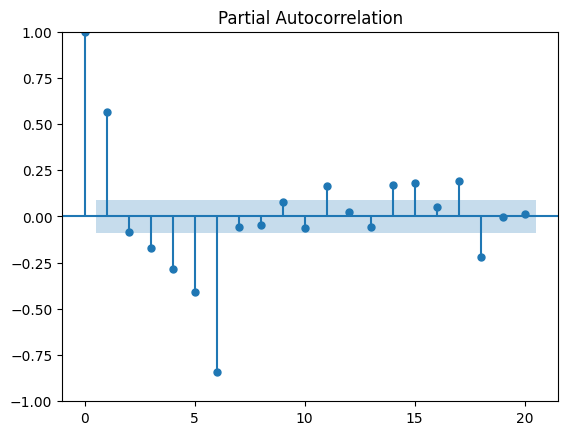

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plot_pacf(coke_df['Diff12'].dropna(), lags=20)
plt.show()

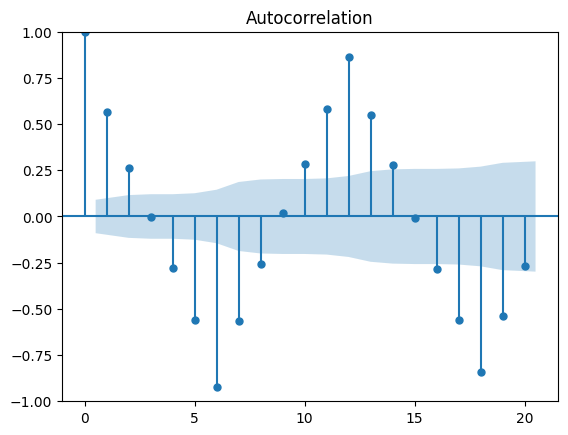

In [280]:
plot_acf(coke_df['Diff12'].dropna(), lags=20)
plt.show()

In [ ]:
# Now SARIMAX predictions
model = SARIMAX(train['cola_production'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
prediction= model_fit.predict(start=test.index[0], end=test.index[-1])
coke_df['sarimaxPred'] = prediction
coke_df.tail()

c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,cola_production,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
yearMonth,,,,,,,
1995-04-01,127.0,152.0,-25.0,-25.0,157.58907,-33.0,155.686536
1995-05-01,151.0,127.0,24.0,24.0,157.58907,-39.0,150.446280
1995-06-01,130.0,151.0,-21.0,-21.0,157.58907,-52.0,141.082516
1995-07-01,119.0,130.0,-11.0,-11.0,157.58907,-19.0,146.442691
1995-08-01,153.0,119.0,34.0,34.0,157.58907,17.0,161.175526


In [ ]:
train = coke_df[:round(len(coke_df)*70/100)]      # take the first 70% data

test = coke_df[round(len(coke_df)*70/100):]       # Take the last 30% data, starting from 71%

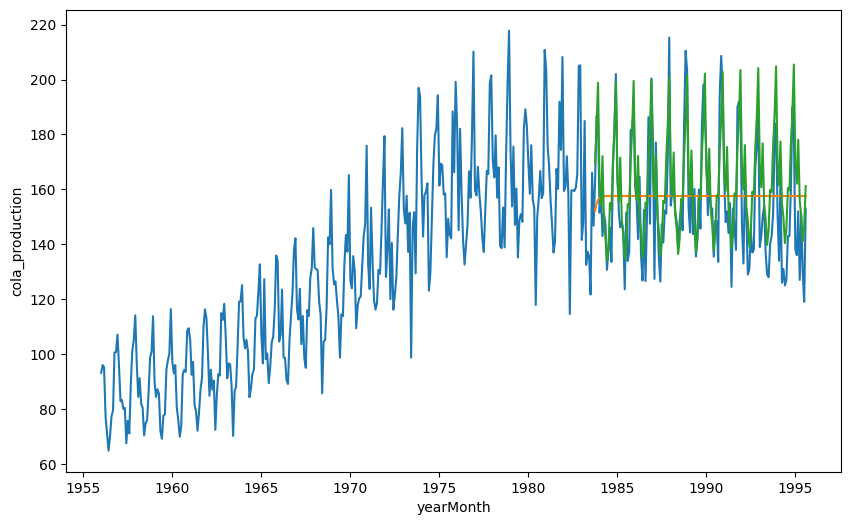

In [ ]:
# plot
plt.figure(figsize=(10,6))
sns.lineplot(data=coke_df, x=coke_df.index, y='cola_production')
sns.lineplot(data=coke_df, x=coke_df.index, y='arimaPred')
sns.lineplot(data=coke_df, x=coke_df.index, y='sarimaxPred')
plt.show()

## Gold Price Dataset

In [4]:
df2 = pd.read_csv("./data_pd/gold_price_data.csv")
df2.head(20)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4
5,1971-04-01,38.9
6,1971-07-01,40.1
7,1971-10-01,42.0
8,1972-01-03,43.5
9,1972-04-03,48.3


In [5]:
df2['Year'] = df2.Date.apply(lambda x: x.split('-')[0])

In [6]:
df2_year = df2.groupby(by='Year').agg({'Value': 'sum'})
df2_year.head(5)

,Value
Year,
1970,141.9
1971,158.4
1972,219.4
1973,371.4
1974,581.0


In [7]:
df2_year['Year'] = df2_year.index

In [8]:
df2_year.head()

,Value,Year
Year,,
1970,141.9,1970
1971,158.4,1971
1972,219.4,1972
1973,371.4,1973
1974,581.0,1974


In [9]:
# Make yearMonth column as the dataframe index
# df2_year.set_index('Year', inplace=True)      # Inplace will make the change permanent to the df2_year
# df2_year.head()

In [10]:
df2_year['Year'] = pd.to_datetime(df2_year['Year'].astype(str))
df2_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 1970 to 2020
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Value   51 non-null     float64       
 1   Year    51 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2+ KB


In [11]:
# By default, shift is by 1 time period (here, one month)
# Create a new column which will contain the shiftedvalue from passengers  column 
df2_year['shift'] = df2_year.Value.shift(1)
df2_year['shiftDiff'] = df2_year['Value'] - df2_year['shift']
df2_year.head(10)

,Value,Year,shift,shiftDiff
Year,,,,
1970,141.9,1970-01-01,NaN,NaN
1971,158.4,1971-01-01,141.9,16.5
1972,219.4,1972-01-01,158.4,61.0
1973,371.4,1973-01-01,219.4,152.0
1974,581.0,1974-01-01,371.4,209.6
1975,671.2,1975-01-01,581.0,90.2
1976,508.4,1976-01-01,671.2,-162.8
1977,580.9,1977-01-01,508.4,72.5
1978,974.8,1978-01-01,580.9,393.9


C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_4348\2494142297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
C:\Users\dbda.STUDENTSDC\AppData\Local\Temp\ipykernel_4348\2494142297.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


Test Statistic                 -1.441274
p-value                         0.562337
#lags used                      8.000000
number of observations used    41.000000
dtype: float64
criticality 1% : -3.60098336718852
criticality 5% : -2.9351348158036012
criticality 10% : -2.6059629803688282


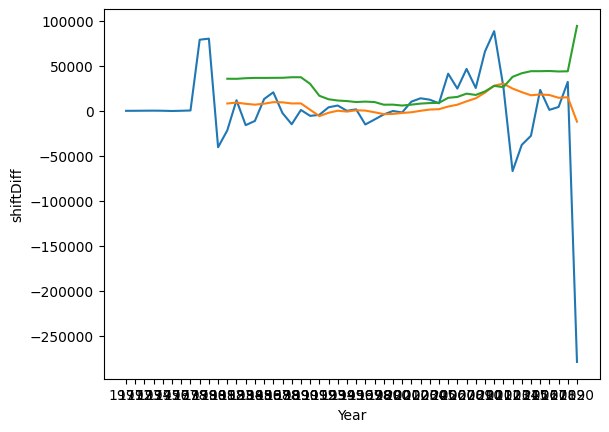

In [13]:
# The previous code to test stationarity is now in a function
def test_stationarity(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var])
    stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observations used'])
    print(stats)
    
    for key, values in adfTest[4].items():
        print('criticality', key, ":", values)
    
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.shiftDiff)  #blue
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollMean)    #yellow
    sns.lineplot(data=dataFrame, x=dataFrame.index, y=dataFrame.rollStd)     #green
    plt.show()

# Test stationarity
test_stationarity(df2_year.dropna(), 'shiftDiff')



In [15]:
# Cretae columns for one month and one year lagged data
df2_year['firstDiff'] = df2_year['Value'].diff()
df2_year.head()



,Value,Year,shift,shiftDiff,firstDiff
Year,,,,,
1970,141.9,1970-01-01,NaN,NaN,NaN
1971,158.4,1971-01-01,141.9,16.5,16.5
1972,219.4,1972-01-01,158.4,61.0,61.0
1973,371.4,1973-01-01,219.4,152.0,152.0
1974,581.0,1974-01-01,371.4,209.6,209.6


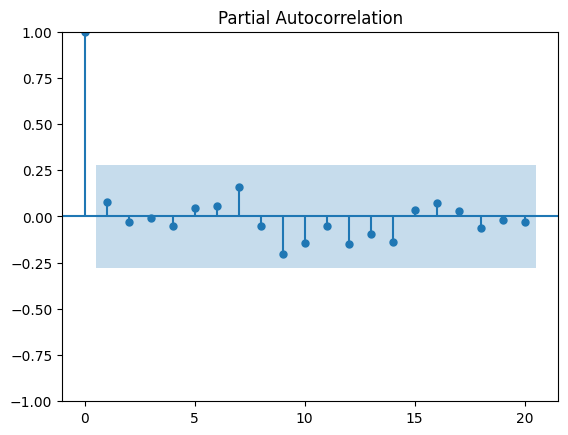

In [18]:
plot_pacf(df2_year['firstDiff'].dropna(), lags=20)
plt.show()



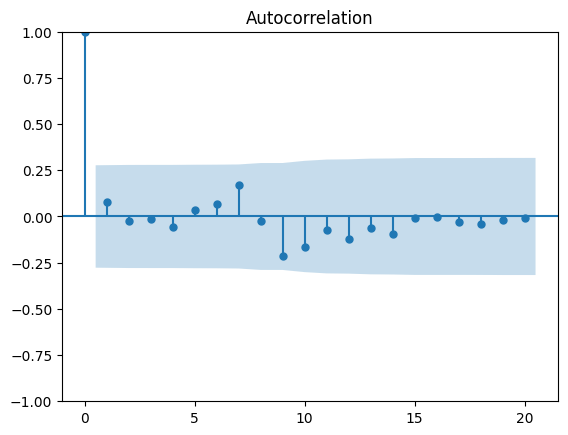

In [19]:
plot_acf(df2_year['firstDiff'].dropna(), lags=20)
plt.show()


c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


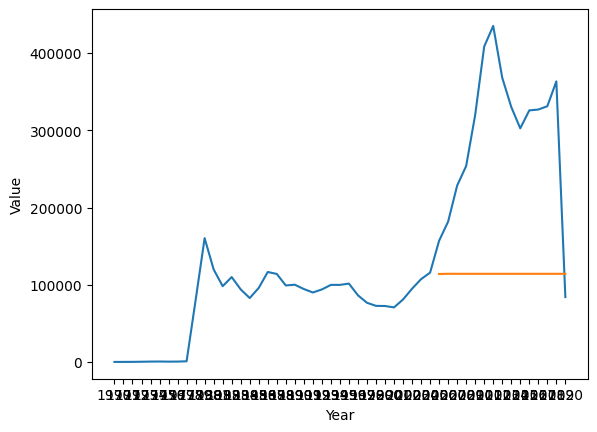

In [20]:
# let us take p = 1, q = 1 (both are significant) and d=2 (already known)
# Build ARIMA Model
train = df2_year[:round(len(df2_year)*70/100)]      # take the first 70% data
train.tail()    # just to check where it ends
test = df2_year[round(len(df2_year)*70/100):]       # Take the last 30% data, starting from 71%
test.head()  
model = ARIMA(train['Value'], order=(1,1,1))       # Parameters: p, d,q
model_fit = model.fit()

prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
df2_year['arimaPred'] = prediction
# plot
sns.lineplot(data=df2_year, x=df2_year.index, y='Value')
sns.lineplot(data=df2_year, x=df2_year.index, y='arimaPred')
plt.show()


In [22]:
df2_year['Diff12'] = df2_year['Value'].diff(12)    #this will show null to start with
df2_year.head(20)


,Value,Year,shift,shiftDiff,firstDiff,arimaPred,Diff12
Year,,,,,,,
1970,141.90,1970-01-01,NaN,NaN,NaN,NaN,NaN
1971,158.40,1971-01-01,141.90,16.50,16.50,NaN,NaN
1972,219.40,1972-01-01,158.40,61.00,61.00,NaN,NaN
1973,371.40,1973-01-01,219.40,152.00,152.00,NaN,NaN
1974,581.00,1974-01-01,371.40,209.60,209.60,NaN,NaN
1975,671.20,1975-01-01,581.00,90.20,90.20,NaN,NaN
1976,508.40,1976-01-01,671.20,-162.80,-162.80,NaN,NaN
1977,580.90,1977-01-01,508.40,72.50,72.50,NaN,NaN
1978,974.80,1978-01-01,580.90,393.90,393.90,NaN,NaN


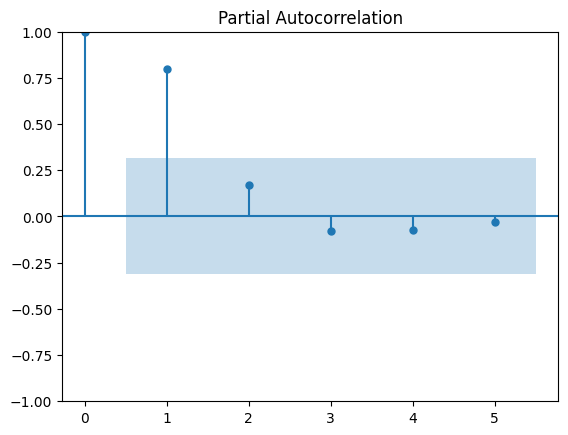

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plot_pacf(df2_year['Diff12'].dropna(), lags=5)
plt.show()


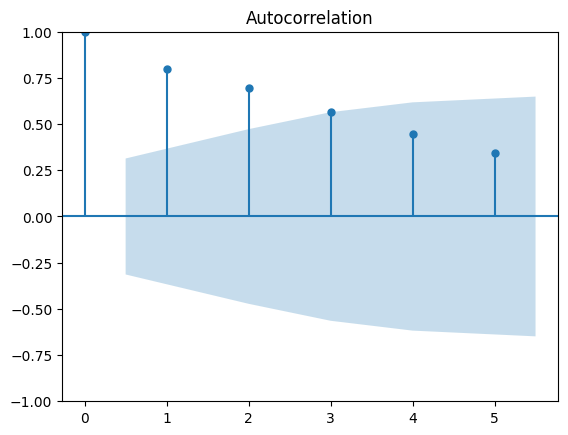

In [25]:
plot_acf(df2_year['Diff12'].dropna(), lags=5)
plt.show()

In [26]:
# Now SARIMAX predictions
model = SARIMAX(train['Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
prediction= model_fit.predict(start=test.index[0], end=test.index[-1])
df2_year['sarimaxPred'] = prediction
df2_year.tail()


c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\dbda.STUDENTSDC\AppData\Local\anaconda3\envs\dung\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


,Value,Year,shift,shiftDiff,firstDiff,arimaPred,Diff12,sarimaxPred
Year,,,,,,,,
2016,325812.9,2016-01-01,302558.45,23254.45,23254.45,114222.877638,218502.00,144839.546035
2017,326902.0,2017-01-01,325812.90,1089.10,1089.10,114222.877641,211200.45,142590.001918
2018,331192.9,2018-01-01,326902.00,4290.90,4290.90,114222.877641,174149.85,143682.197575
2019,363397.9,2019-01-01,331192.90,32205.00,32205.00,114222.877641,181606.70,146230.873127
2020,84107.3,2020-01-01,363397.90,-279290.60,-279290.60,114222.877641,-144317.80,142605.797735


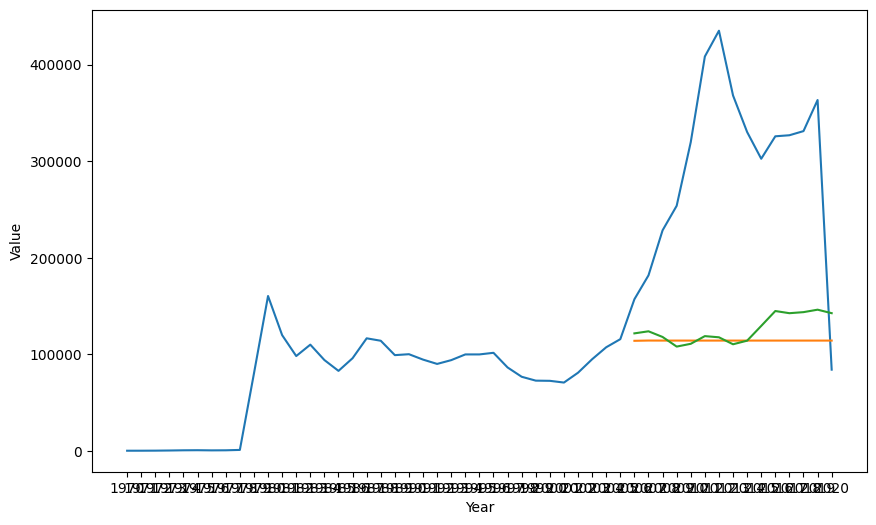

In [27]:
train = df2_year[:round(len(df2_year)*70/100)]      # take the first 70% data

test = df2_year[round(len(df2_year)*70/100):]       # Take the last 30% data, starting from 71%
# plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df2_year, x=df2_year.index, y='Value')
sns.lineplot(data=df2_year, x=df2_year.index, y='arimaPred')
sns.lineplot(data=df2_year, x=df2_year.index, y='sarimaxPred')
plt.show()